In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml


import warnings
warnings.filterwarnings('ignore')

In [3]:
config = f"""
dataset: 
    base_path: /kaggle/input/child-mind-institute-detect-sleep-states

seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

In [4]:
STEPS_PER_DAY = int(60 * 60 * 24 / 5) # 5秒で1step

In [5]:
train = pd.read_parquet(f'{CFG["dataset"]["base_path"]}/train_series.parquet')
train

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199


In [6]:
train["series_id"].nunique()

277

シリーズの個数は277個

In [7]:
train_events = pd.read_csv(f'{CFG["dataset"]["base_path"]}/train_events.csv')
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14505,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14506,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14507,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14508,fe90110788d2,35,onset,NaN,NaN


In [8]:
train_events["step"].isna().mean()

0.33928325292901446

34%くらいは正解ラベルが欠損してる

In [20]:
train_events.groupby("series_id")["night"].max().sum()

7259

7200日分くらいのデータがある。

In [9]:
train = train.merge(train_events[["series_id", "step", "event"]], on=["series_id", "step"], how="left")

In [10]:
train

,series_id,step,timestamp,anglez,enmo,event
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217,NaN
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215,NaN
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216,NaN
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213,NaN
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215,NaN
...,...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204,NaN
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233,NaN
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202,NaN
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199,NaN


In [13]:
train["hour"] = train["timestamp"].str[-13:-11].astype(int)
train["minute"] = train["timestamp"].str[-10:-8].astype(int)
train["second"] = train["timestamp"].str[-7:-5].astype(int)

In [15]:
train["step_of_day"] = train["hour"] * 60 * 60 // 5 + train["minute"] * 60 // 5 + train["second"] // 5

In [16]:
train["event"].value_counts()

wakeup    4794
onset     4793
Name: event, dtype: int64

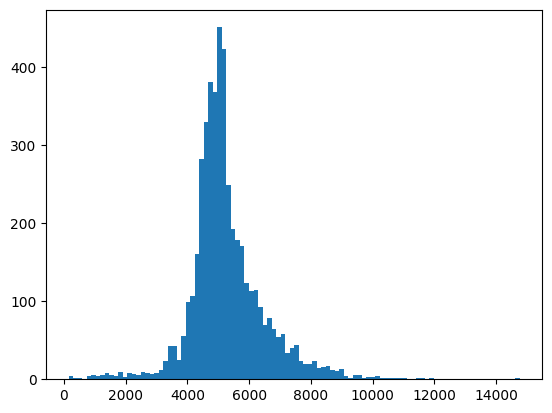

In [18]:
train_wakeup = train[train["event"] == "wakeup"]
plt.hist(train_wakeup["step_of_day"], bins=100)
plt.show()

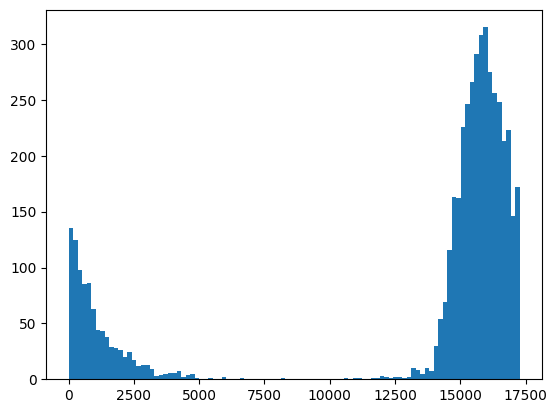

In [19]:
train_onset = train[train["event"] == "onset"]
plt.hist(train_onset["step_of_day"], bins=100)
plt.show()